In [1]:
from river.river import River
from river.preprocess import do_slat_pair, get_the_feature, seed_everything
import pysodb 
import scanpy as sc
import numpy as np
import anndata as ad

from collections import defaultdict


sodb = pysodb.SODB()

seed_everything(42)

import squidpy as sq

patient_condition_dict = {
    'p1':'Mixed',
    'p2':'Mixed',
    'p3':'Compartmentalized',
    'p4':'Compartmentalized',
    'p5':'Compartmentalized',
    'p6':'Compartmentalized',
    'p7':'Mixed',
    'p8':'Mixed',
    'p9':'Compartmentalized',
    'p10':'Compartmentalized',
    'p11':'Mixed',
    'p12':'Mixed',
    'p13':'Mixed',
    'p14':'Mixed',
    'p15':'Cold',
    'p16':'Compartmentalized',
    'p17':'Mixed',
    'p18':'Mixed',
    'p19':'Cold',
    'p20':'Mixed',
    'p21':'Mixed',
    'p22':'Cold',
    'p23':'Mixed',
    'p24':'Cold',
    'p25':'Cold',
    'p26':'Cold',
    'p27':'Mixed',
    'p28':'Compartmentalized',
    'p29':'Mixed',
    'p31':'Mixed',
    'p32':'Compartmentalized',
    'p33':'Mixed',
    'p34':'Compartmentalized',
    'p35':'Compartmentalized',
    'p36':'Compartmentalized',
    'p37':'Compartmentalized',
    'p38':'Mixed',
    'p39':'Mixed',
    'p40':'Compartmentalized',
    'p41':'Compartmentalized',    
}


adata_list = []
experiment_list = sodb.list_experiment_by_dataset('keren2018a')
adata = sodb.load_experiment('keren2018a', 'p1')
sc.pp.subsample(adata, n_obs=2000)
adata.obs['label'] = 'Mixed'
adata_list.append(adata)
adata = sodb.load_experiment('keren2018a', 'p3')
sc.pp.subsample(adata, n_obs=2000)
adata.obs['label'] = 'Compartmentalized'
adata_list.append(adata)
adata = sodb.load_experiment('keren2018a', 'p19')
sc.pp.subsample(adata, n_obs=2000)
adata.obs['label'] = 'Cold'
adata_list.append(adata)

rem_adata_list = []
label_list = []
y = []
X_1 = []
X_2 = []
X_3 = []
X_full = []


final_ranks = np.load('final_rank_tnbc.npy', allow_pickle=True)

for key, value in patient_condition_dict.items():
    if (key != 'p1') & (key != 'p3')  & (key != 'p19'):
        adata = sodb.load_experiment('keren2018a', key)
        adata.obs['label'] = value
        y.append(value)
        rem_adata_list.append(adata)      

rem_adata = ad.concat(rem_adata_list, label='slice_id')

X_list = []
X_ctrl_list = []
np.random.seed(42)
random_ranks = np.random.permutation(np.arange(final_ranks.shape[0]))

for i in range(0, final_ranks.shape[0], 2):
    X_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s, final_ranks[:min(i+2, final_ranks.shape[0])]].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
    X_ctrl_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s, random_ranks[:min(i+2, final_ranks.shape[0])]].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
    
X_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))
X_ctrl_list.append(np.stack([rem_adata[rem_adata.obs['slice_id'] == s].X.mean(0)  for s in rem_adata.obs['slice_id'].unique()]))

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


load experiment[p1] in dataset[keren2018a]
load experiment[p3] in dataset[keren2018a]
load experiment[p19] in dataset[keren2018a]
load experiment[p2] in dataset[keren2018a]
load experiment[p4] in dataset[keren2018a]
load experiment[p5] in dataset[keren2018a]
load experiment[p6] in dataset[keren2018a]
load experiment[p7] in dataset[keren2018a]
load experiment[p8] in dataset[keren2018a]
load experiment[p9] in dataset[keren2018a]
load experiment[p10] in dataset[keren2018a]
load experiment[p11] in dataset[keren2018a]
load experiment[p12] in dataset[keren2018a]
load experiment[p13] in dataset[keren2018a]
load experiment[p14] in dataset[keren2018a]
load experiment[p15] in dataset[keren2018a]
load experiment[p16] in dataset[keren2018a]
load experiment[p17] in dataset[keren2018a]
load experiment[p18] in dataset[keren2018a]
load experiment[p20] in dataset[keren2018a]
load experiment[p21] in dataset[keren2018a]
load experiment[p22] in dataset[keren2018a]
load experiment[p23] in dataset[keren2018

In [ ]:
matching_list = []

for i, adata in enumerate(adata_list[1:]):
    _, best =  do_slat_pair(adata_list[0], adata, feature='raw')
    matching_list.append(best[0])
gene_expression, spatial, y, overlap = get_the_feature(adata_list, matching_list)
model = River(gene_expression=gene_expression, spatial=spatial, label=y)
model.train(epoch=100)
ig_attribution, dl_attribution, sl_attribution = model.attribution()
model.summary_attribution(ig_attribution, dl_attribution, sl_attribution, overlap)
model.return_top_k_gene(top_k=200)

np.save('final_rank_tnbc', model.final_rank.index.values)
np.save('ig_tnbc', model.scores_ig)
np.save('dl_tnbc', model.scores_dl)
np.save('sl_tnbc', model.scores_sl)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Perform 5-fold cross-validation for different subsets of features
results = {}
means_1 = []
std_1 = []
methods = []

for i, X in enumerate(X_list):
    clf = SVC(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_1.append(scores.mean())
    std_1.append(scores.std())



# Converting results to DataFrame for easy plotting
'''results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_2 = []
std_2 = []


for i, X in enumerate(X_list):
    clf =  RandomForestClassifier(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_2.append(scores.mean())
    std_2.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Creating line chart with error bars
# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_3 = []
std_3 = []


for i, X in enumerate(X_list):
    clf =  LogisticRegression(random_state=13)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_3.append(scores.mean())
    std_3.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)



# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


"plt.figure(figsize=(10, 10))\nimport seaborn as sns\nax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', \n                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])"

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Perform 5-fold cross-validation for different subsets of features
results = {}
means_c_1 = []
std_c_1 = []
methods = []

for i, X in enumerate(X_ctrl_list):
    clf = SVC(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_c_1.append(scores.mean())
    std_c_1.append(scores.std())


# Converting results to DataFrame for easy plotting
'''results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_c_2 = []
std_c_2 = []


for i, X in enumerate(X_ctrl_list):
    clf =  RandomForestClassifier(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_c_2.append(scores.mean())
    std_c_2.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


results = {}
means_c_3 = []
std_c_3 = []


for i, X in enumerate(X_ctrl_list):
    clf =  LogisticRegression(random_state=13)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_ctrl_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores
    means_c_3.append(scores.mean())
    std_c_3.append(scores.std())
# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
'''plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])'''


"plt.figure(figsize=(10, 10))\nimport seaborn as sns\nax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', \n                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


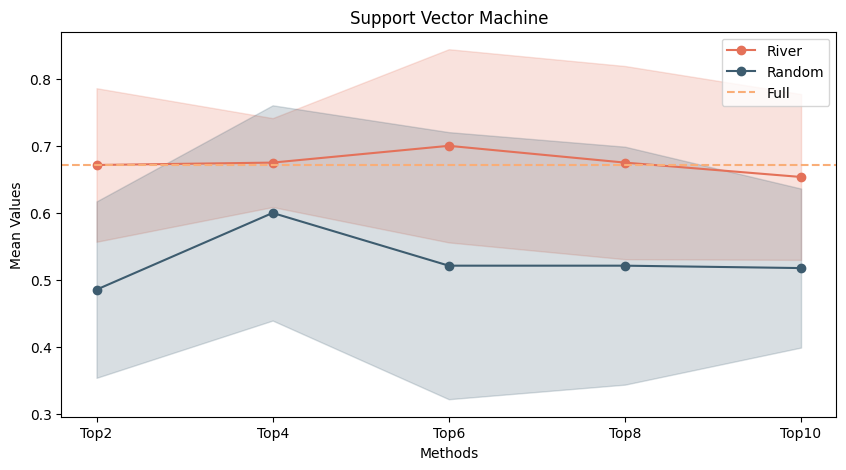

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


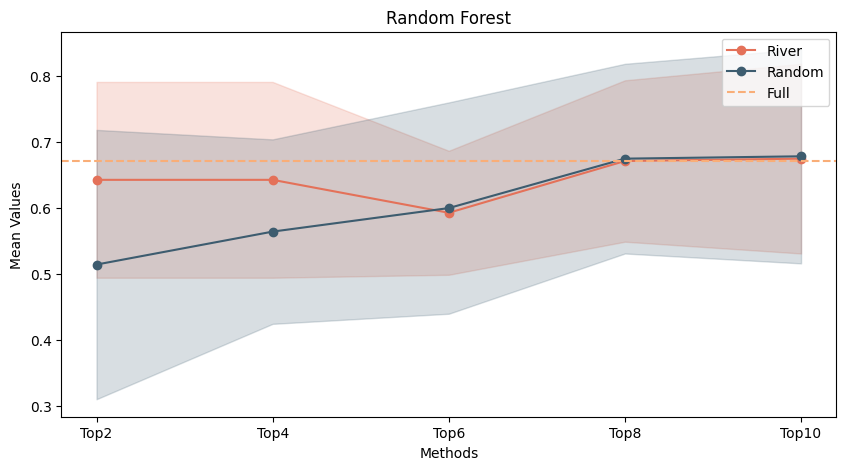

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


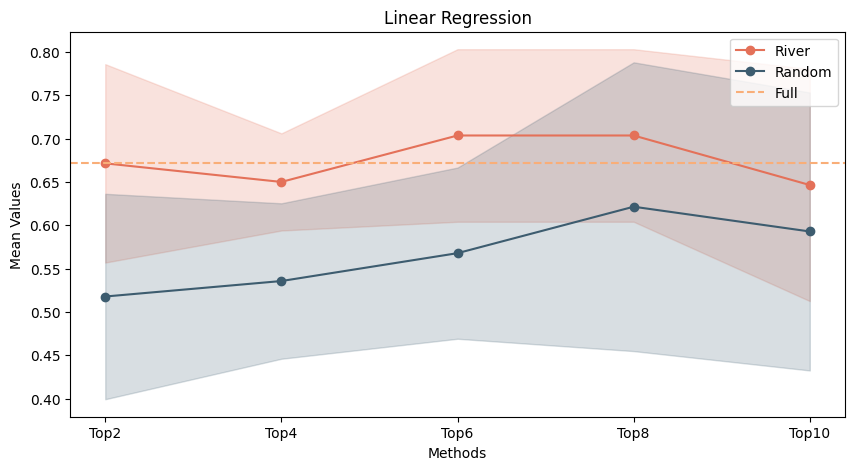

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
methods = ['Top2', 'Top4', 'Top6', 'Top8', 'Top10']
group1_means = np.array(means_1[:5])
group2_means = np.array(means_c_1[:5])
group1_stds = np.array(std_1[:5])
group2_stds = np.array(std_c_1[:5])


plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Methods')
plt.ylabel('Mean Values')
plt.title('Support Vector Machine')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()


import matplotlib.pyplot as plt
import numpy as np


group1_means = np.array(means_2[:5])
group2_means = np.array(means_c_2[:5])
group1_stds = np.array(std_2[:5])
group2_stds = np.array(std_c_2[:5])

# Creating line chart for two groups
plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Methods')
plt.ylabel('Mean Values')
plt.title('Random Forest')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()


import matplotlib.pyplot as plt
import numpy as np


group1_means = np.array(means_3[:5])
group2_means = np.array(means_c_3[:5])
group1_stds = np.array(std_3[:5])
group2_stds = np.array(std_c_3[:5])



plt.figure(figsize=(10, 5))
plt.plot(methods, group1_means, '-o', label='River', color='#E47159')  # Plot for Group 1
plt.fill_between(methods, group1_means - group1_stds, group1_means + group1_stds, color='#E47159', alpha=0.2)
plt.plot(methods, group2_means, '-o', label='Random', color='#3D5C6F')   # Plot for Group 2
plt.fill_between(methods, group2_means - group2_stds, group2_means + group2_stds, color='#3D5C6F', alpha=0.2)
plt.axhline(y=means_3[-1], color='#F9AE78', linestyle='--', label='Full')
plt.xlabel('Methods')
plt.ylabel('Mean Values')
plt.title('Linear Regression')
plt.legend()  # Adds a legend to differentiate between the two groups
plt.show()



In [ ]:
import anndata as ad
import matplotlib.pyplot as plt

label_palette = ['#f3f6ed', '#a9c1c8', '#abd064', '#a1cfe6', '#b68e96', '#eebab8', '#EDB11A', '#D75515']

with plt.rc_context({"figure.figsize": (10, 10)}):
    final_ranks = np.load('final_rank_tnbc.npy', allow_pickle=True)
    our_genes = final_ranks[:5]
    predictive_adata = ad.concat(rem_adata_list, label='slice_id')[:, our_genes]
    sc.pp.neighbors(predictive_adata)
    sc.tl.umap(predictive_adata)
    ax = sc.pl.umap(predictive_adata, color=['label'], show=False,  palette=['#abd064', '#a1cfe6', '#b68e96'])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



# Perform 5-fold cross-validation for different subsets of features
results = {}

X_list = [X_1, X_2, X_3, X_full]

for i, X in enumerate(X_list):
    clf = SVC(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores

# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])


results = {}

X_list = [X_1, X_2, X_3, X_full]

for i, X in enumerate(X_list):
    clf =  RandomForestClassifier(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores

# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])



results = {}

X_list = [X_1, X_2, X_3, X_full]

for i, X in enumerate(X_list):
    clf = LogisticRegression(random_state=42)
    # StratifiedKFold preserves the percentage of samples for each class.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_list[i], y, cv=cv, scoring='accuracy')
    results[i] = scores

# Converting results to DataFrame for easy plotting
results_df = pd.DataFrame(results)


# Plotting
plt.figure(figsize=(10, 10))
import seaborn as sns
ax = sns.heatmap(results_df.T, cbar=False, annot=True, fmt='.2f', cmap='flare', 
                 yticklabels=['Top-3', 'Top-5', 'Top-10', 'Full'], xticklabels=['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5'])


/tmp/ipykernel_1201118/3075518646.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


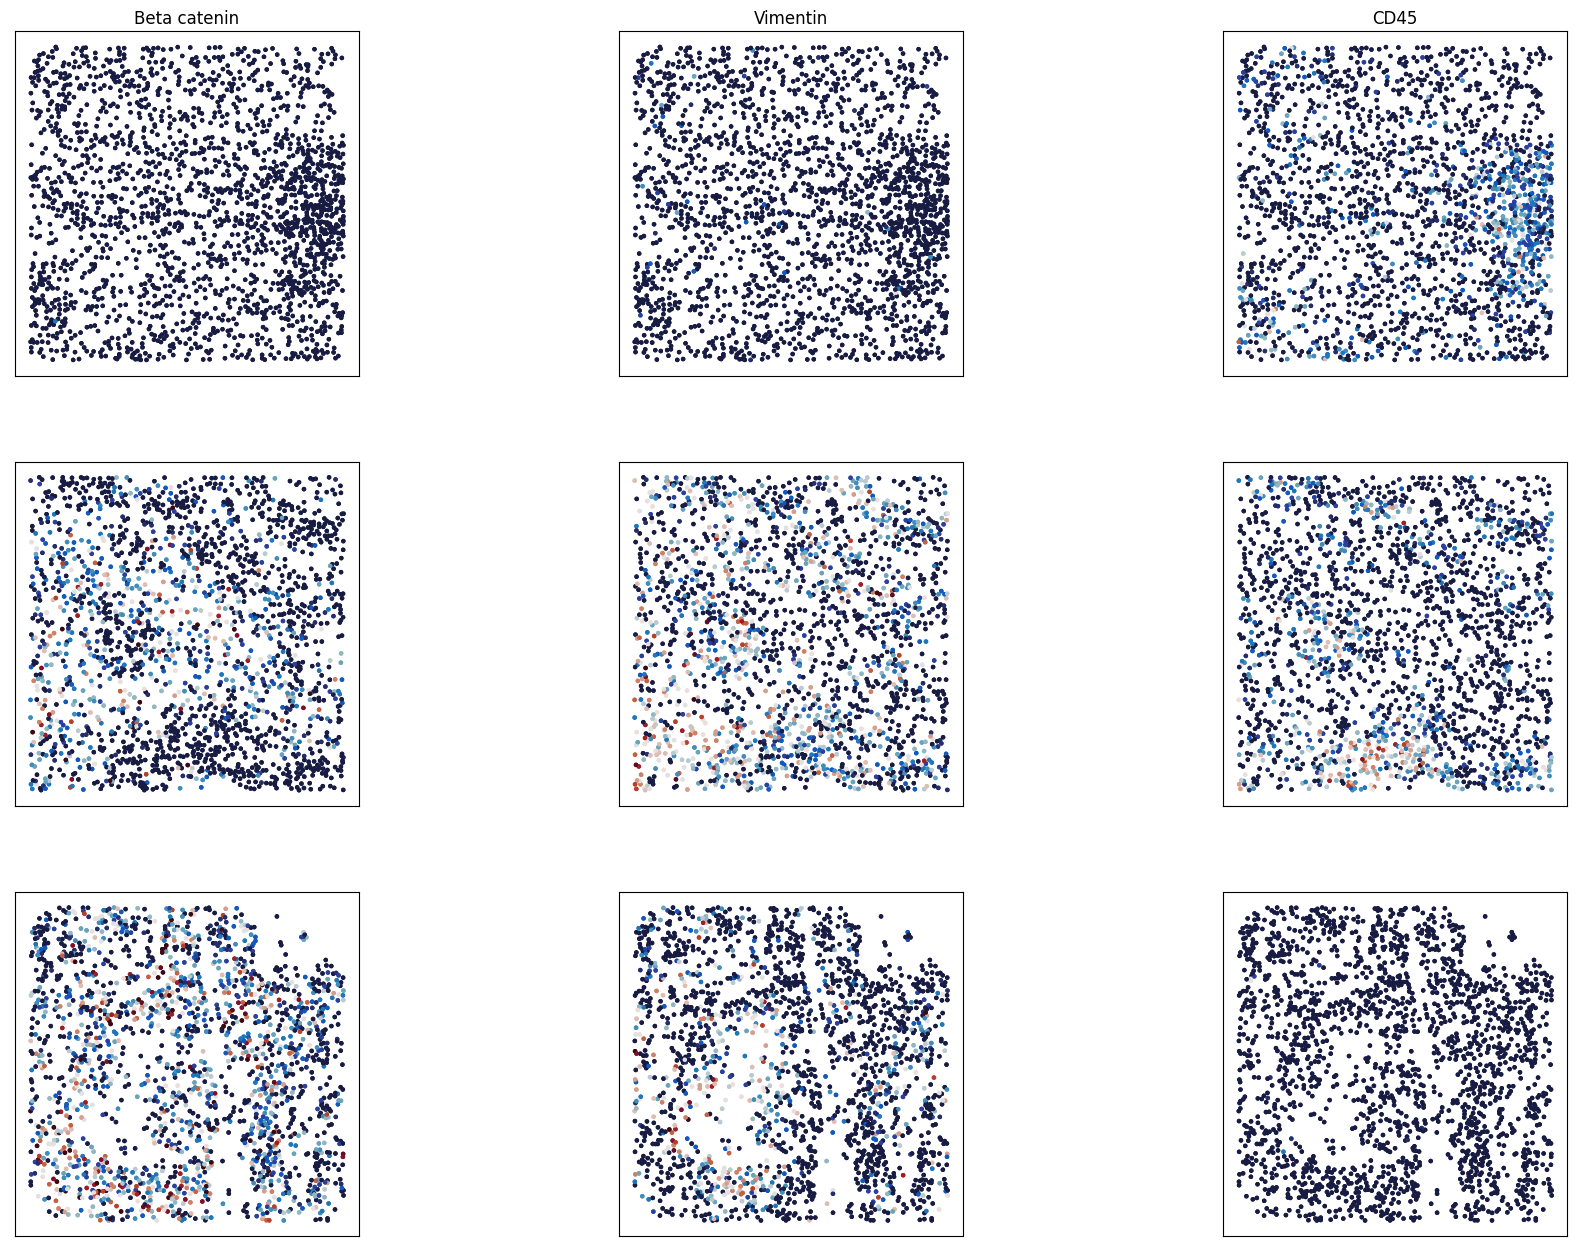

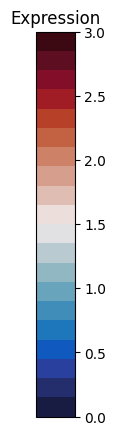

In [10]:
import squidpy as sq 
import anndata as ad
import matplotlib.pyplot as plt

adata = ad.concat(adata_list, label='slice_id')

from palettable.cmocean.diverging import Delta_20, Balance_20

from matplotlib.colors import  ListedColormap

r1 = np.load('final_rank_tnbc.npy', allow_pickle=True)

#norm = plt.Normalize(adata[:, [r1[0], r1[1], r1[2]]].X.min(), adata[:, [r1[0], r1[1], r1[2]]].X.max())

norm = plt.Normalize(0, 3)
cmap = ListedColormap(Balance_20.mpl_colors)


g = sq.pl.spatial_scatter(adata, shape=None, color=[r1[0], r1[1], r1[2]], ncols=3, library_key='slice_id', cmap=cmap, return_ax=True, norm=norm,colorbar=False)
fig_colorbar, ax_colorbar = plt.subplots(figsize=(0.5, 5))
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_colorbar)
ax_colorbar.set_title('Expression')

for i, ax in enumerate(g):
    if i > 2:
        ax.set_title('') 
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout()
plt.show()


/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


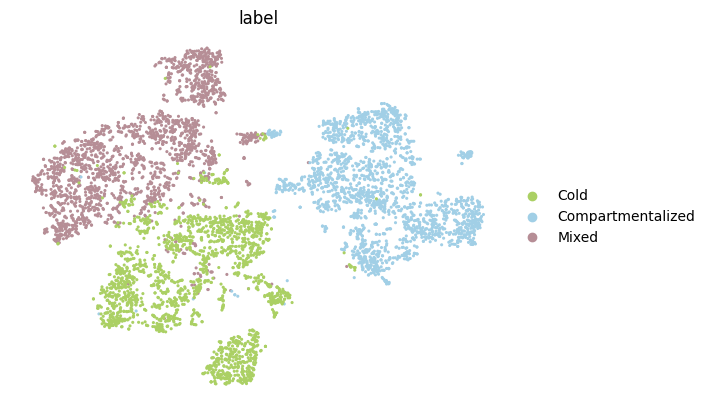

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


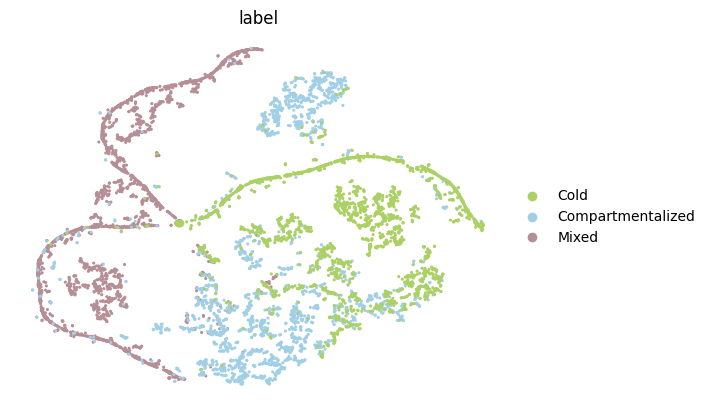

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/tools/_tsne.py:155: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm['X_tsne'] = X_tsne  # annotate samples with tSNE coordinates
/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


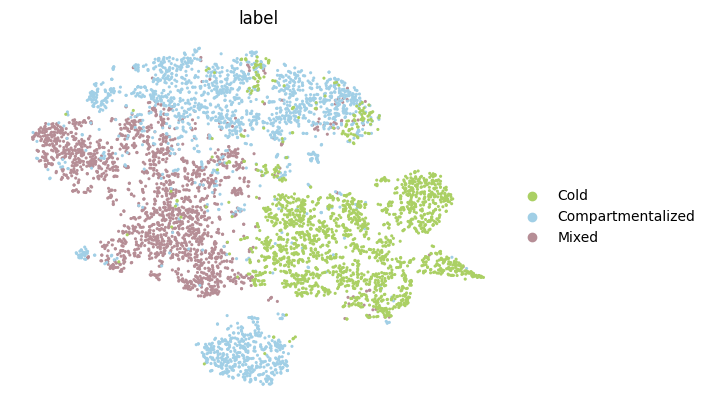

/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/tools/_tsne.py:155: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  adata.obsm['X_tsne'] = X_tsne  # annotate samples with tSNE coordinates
/data/civy/miniconda3/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


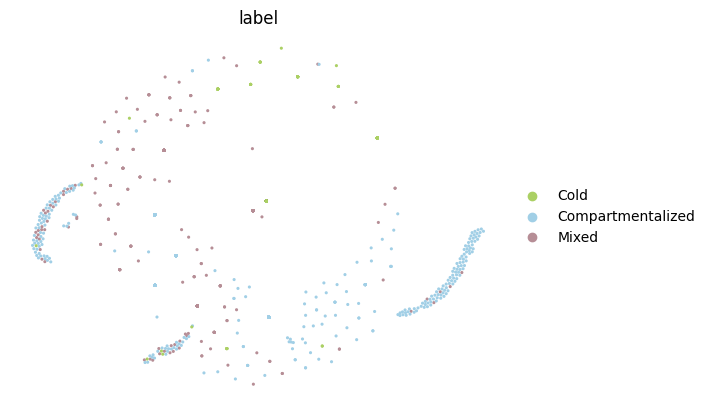

In [8]:
import anndata as ad

final_ranks = np.load('final_rank_tnbc.npy', allow_pickle=True)
our_genes = final_ranks[:5]

scores_ig = np.load('ig_tnbc.npy')

scores_sl = np.load('sl_tnbc.npy')

scores_dl = np.load('dl_tnbc.npy')

adata_t = ad.concat(adata_list, label='slice_id')[:5984, our_genes]

adata_t = ad.AnnData(X=adata_t.X.toarray(), obs=adata_t.obs)

adata_t.obsm['ig'] = scores_ig
adata_t.obsm['dl'] = scores_dl
adata_t.obsm['sl'] = scores_sl


sc.tl.tsne(adata_t, use_rep='ig')
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#abd064', '#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


sc.tl.tsne(adata_t)
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#abd064', '#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


adata_all =  ad.concat(adata_list, label='slice_id')[:5984]
sc.tl.tsne(adata_all)
ax = sc.pl.tsne(adata_all, color='label', show=False, palette=['#abd064', '#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


our_genes = final_ranks[-5:]
adata_t = ad.concat(adata_list, label='slice_id')[:5984, our_genes]
sc.tl.tsne(adata_t)
ax = sc.pl.tsne(adata_t, color='label', show=False, palette=['#abd064', '#a1cfe6', '#b68e96'])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


In [ ]:
adata_t.obsm['ig'] = scores_ig
adata_t.obsm['dl'] = scores_dl
adata_t.obsm['sl'] = scores_sl

adata_tt = adata_t[:2000].copy()

sc.pp.neighbors(adata_tt, use_rep='ig')
sc.tl.umap(adata_tt)
ax = sc.pl.umap(adata_tt, color=['group_name'], show=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


sc.pp.neighbors(adata_tt, use_rep='dl')
sc.tl.umap(adata_tt)
ax = sc.pl.umap(adata_tt, color=['group_name'], show=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


sc.pp.neighbors(adata_tt, use_rep='sl')
sc.tl.umap(adata_tt)
ax = sc.pl.umap(adata_tt, color=['group_name'], show=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()